In [251]:
import pandas as pd
import scipy.stats as sps
import numpy as np
from collections import defaultdict
import psycopg2
import re
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime,timedelta
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
import copy

In [2]:
projects = ['ru.stackoverflow.com','datascience.stackexchange.com','arduino.stackexchange.com',
            'cstheory.stackexchange.com','sqa.stackexchange.com','softwareengineering.stackexchange.com',
            'stats.stackexchange.com', 'ai.stackexchange.com','cseducators.stackexchange.com']

In [3]:
# отправить SQL запрос в нашу БД
def data_request(request):
    connection = psycopg2.connect(dbname='sinya', user='postgres', 
                        password='11111', host='127.0.0.1')
    cursor = connection.cursor()
    cursor.execute(request)
    records = cursor.fetchall()
    cursor.close()
    connection.close()
    return records

def split_tags(string):
    raw_tags = re.findall('<.*?>', string) 
    tags = [re.sub(r'<(.*?)>', r'\1', tag) for tag in raw_tags ]
    return tags


# разбить список тегов на отдельные, построить словарь частот
def dict_of_tags(data,split_fun = split_tags):
    d = defaultdict(int)
    for unit in data:
        if unit[0]:
            for tag in split_fun(unit[0]):
                d[tag] +=1
    return d

# перевести все веса в словаре в проценты от суммарного веса словаря
def dict_to_percents(dictionary):
    if dictionary == {}:
        return dictionary
    tag,counts = zip(*dictionary.items())
    total = np.array(counts).sum()
    for key in dictionary:
        dictionary[key] /= (total/100)
    return dictionary

#выбрать из словаря самые популярные
def list_of_popular_tags(dictionary, top = 5):
    tags = list(dictionary.items())
    tags.sort(key=lambda p: -p[1])
    return tags[:top]



# выберите проект и число самых популярных тегов для просмотра
project_id = 8
top = 12

#data = data_request(f'SELECT tags FROM public.posts WHERE project_id = 1 limit {i};')
data = data_request(f'SELECT "Tags" FROM public.posts WHERE "ProjectId" = {project_id} AND "Tags" IS NOT NULL;')
top_10 = list_of_popular_tags(dict_of_tags(data),top)

In [346]:
def plot_hist_top_n(top_n, project_id, ylabel, xlabel = 'Tags'):
    names,counts = zip(*top_n)
    plt.figure(figsize=[15, 7])
    plt.title(f'Top {top} {xlabel} in Posts on {projects[project_id-1]} ', fontsize=20)
    plt.ylabel(ylabel, fontsize=15)
    plt.xlabel(xlabel, fontsize=15)
    plt.xticks(rotation=65)
    plt.bar(names,counts, width=0.9)
    plt.show()

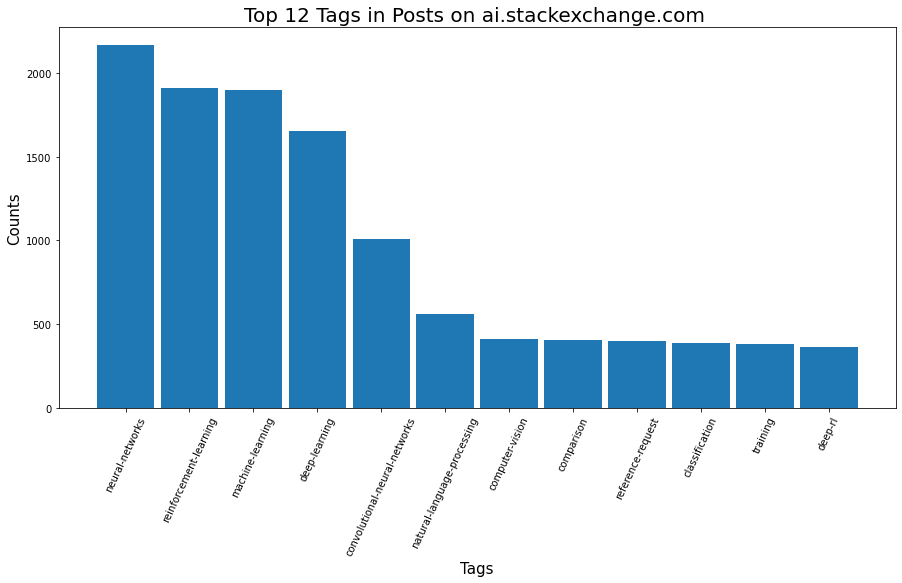

In [5]:
# самые популярные теги проекта за всю историю по числу постов
plot_hist_top_n(top_10, project_id, ylabel = "Counts")

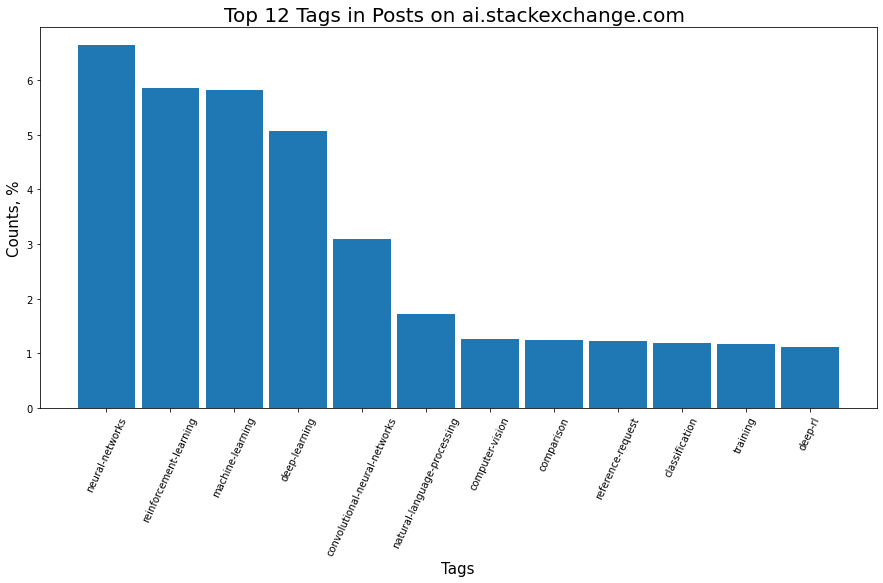

In [6]:
# самые популярные теги проекта за всю историю по числу постов  в процентах от общего числа
top_10 = list_of_popular_tags(dict_to_percents(dict_of_tags(data)), top)
plot_hist_top_n(top_10, project_id, ylabel = "Counts, %")

In [7]:
# топ тегов по годам

def top_tags_per_years(project_id,start_year,final_year,top, tags, show = True, in_percents = True):
    years = []
    counts = defaultdict(list)

    for year in range(start_year,final_year + 1):
        data = data_request(f'SELECT "Tags" FROM public.posts WHERE "ProjectId" = {project_id} AND "LastActivityDate" < \'{year}-01-01\' ;')
        if in_percents:
            d = dict_to_percents(dict_of_tags(data))
        else:
            d = dict_of_tags(data)
        top_n = list_of_popular_tags(d,top)
        years.append(year)
        for tag in tags:
            counts[tag].append(d[tag])
        if show:
            print(year, top_n)
    return (counts,years)
        


In [8]:
def plot_lineplot(counts,years,ylabel):
    plt.figure(figsize=(15, 8))
    sns.set_theme(style="whitegrid")
    data = pd.DataFrame(list(map(list, zip(*counts.values()))) , years, columns= tags)
    ax = sns.lineplot(data=data, palette="tab10", linewidth=2.5)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Year")

2010 []
2011 []
2012 []
2013 []
2014 []
2015 []
2016 []
2017 [('neural-networks', 8.366533864541834), ('image-recognition', 3.9840637450199208), ('machine-learning', 3.9840637450199208), ('agi', 3.5856573705179287), ('research', 3.1872509960159365)]
2018 [('neural-networks', 10.840108401084011), ('machine-learning', 8.401084010840108), ('deep-learning', 5.826558265582656), ('image-recognition', 4.742547425474255), ('convolutional-neural-networks', 4.065040650406504)]
2019 [('neural-networks', 11.29032258064516), ('machine-learning', 8.93635571054926), ('deep-learning', 6.102877070619006), ('convolutional-neural-networks', 4.272013949433304), ('reinforcement-learning', 3.8796861377506535)]
2020 [('neural-networks', 9.213630406290957), ('machine-learning', 8.034076015727392), ('deep-learning', 5.858453473132372), ('reinforcement-learning', 5.6487549148099605), ('convolutional-neural-networks', 3.866317169069463)]
2021 [('neural-networks', 7.613289504578539), ('reinforcement-learning', 6.

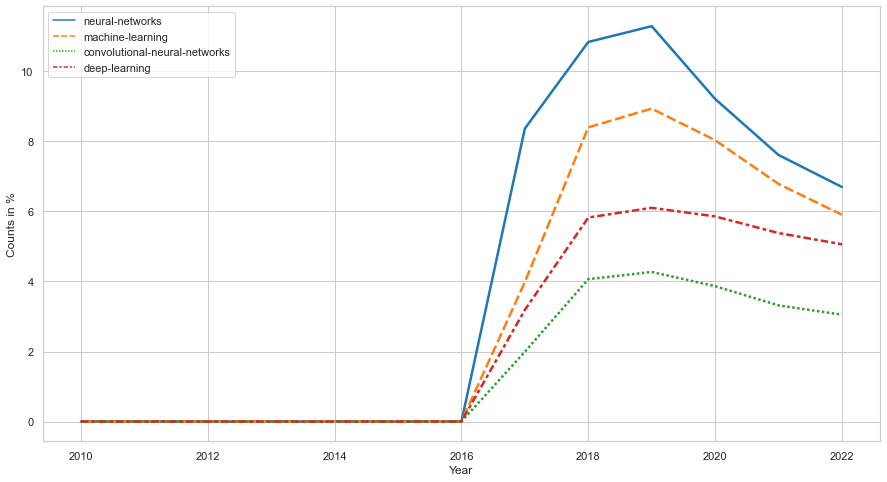

In [9]:
# число постов с данным тегом по годам
tags = ['neural-networks','machine-learning','convolutional-neural-networks','deep-learning']
counts, years = top_tags_per_years(8,2010,2022,5, tags, show = 1, in_percents = True)
plot_lineplot(counts,years,ylabel = 'Counts in %')

In [10]:
def delta(arr):
    delta = []
    prev_el = arr[0]
    for cur_el in arr[1:]:
        delta.append(cur_el - prev_el)
        prev_el = cur_el
    return delta

def count_deltas(counts):
    deltas = {}
    for tag in counts.keys():
        deltas[tag] = delta(counts[tag])
    return deltas

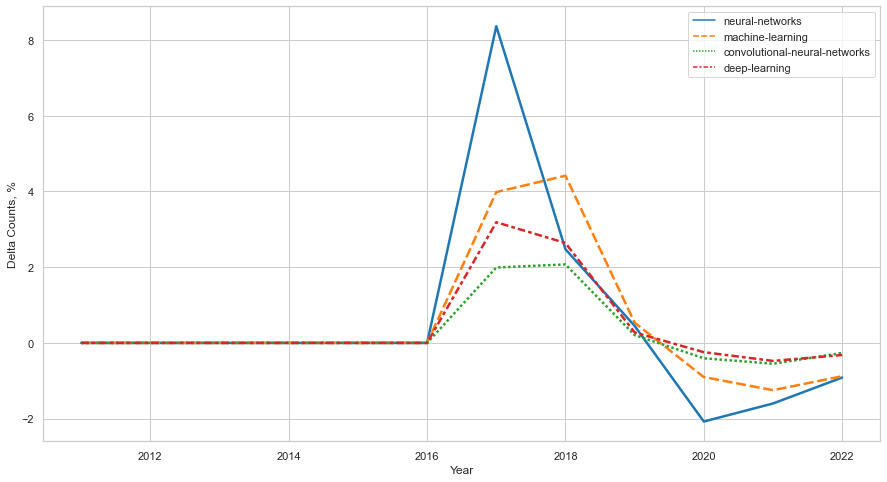

In [11]:
# годовой прирост числа постов с данным тегом
deltas = count_deltas(counts)
plot_lineplot(deltas,years[1:],ylabel = 'Delta Counts, %')

In [12]:
# подсчет вес = view_count/число дней существования поста


# разбить список тегов на отдельные, построить словарь весов
def weight_dict_of_tags(data,pub_date, split_fun = split_tags):
    d = defaultdict(float)
    for unit in data:
        if unit[0] is not None:
            view_count = unit[1]
            life_time = (pub_date  - unit[2].date())/ timedelta(days = 1)
            weight = view_count/life_time
            for tag in split_fun(unit[0]):
                d[tag] +=weight
    return d


# выберите проект и число самых популярных тегов для просмотра
project_id = 8
top = 10

data = data_request(f'SELECT "Tags","ViewCount","CreationDate" FROM public.posts WHERE "ProjectId" = {project_id} ;')
pub_date = data_request(f'SELECT "publication_date" FROM projects WHERE "id" = {project_id} ;')[0][0]
top_10 = list_of_popular_tags(dict_to_percents(weight_dict_of_tags(data,pub_date)),top)



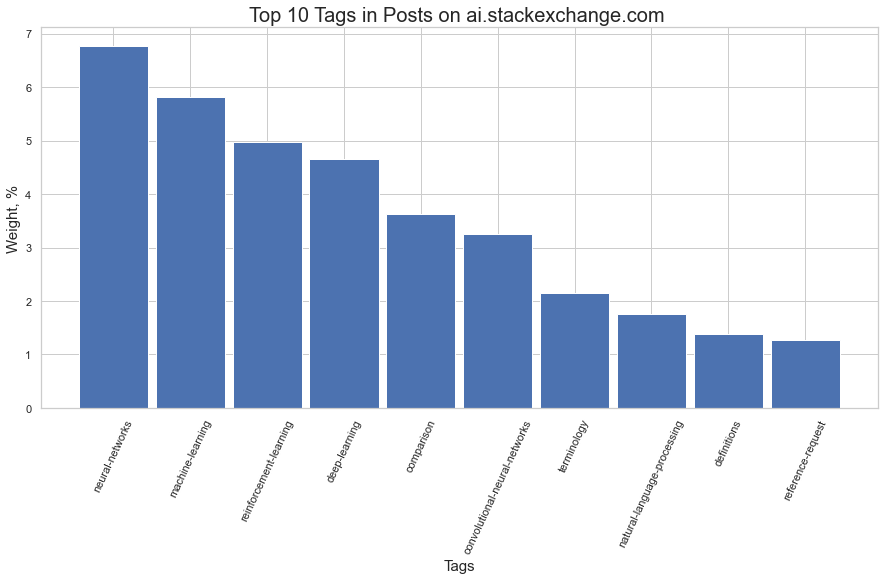

In [13]:
# самые популярные теги проекта за всю историю по весу
plot_hist_top_n(top_10, project_id, ylabel = 'Weight, %')

In [68]:

def plot_2_hist(project_id,tags,first,second,first_label,second_label):
    # Visualizing the data with multiple bar chart
    plt.figure(figsize=[15, 9])

    # Set the width of the bars
    wd = 0.7
    x_pos = np.arange(1, 2*len(tags), 2)

    # Plotting the multiple bar graphs on the same figure
    plt.bar(x_pos, first, color='r', width=wd, edgecolor='k',
        label=first_label)
    plt.bar(x_pos+wd, second, color='b', width=wd, edgecolor='k', 
        label=second_label)

    # Add xticks
    plt.xticks(x_pos+wd, tags, fontsize=15, rotation=80)
    plt.yticks(fontsize=15)
    plt.title(f'Top {len(top_100)} Tags in Posts on {projects[project_id-1]}', fontsize=20)
    plt.xlabel('Tags', fontsize=17)
    plt.ylabel('%', fontsize=17)

    plt.legend(loc='upper center', fontsize=15)
    plt.show()

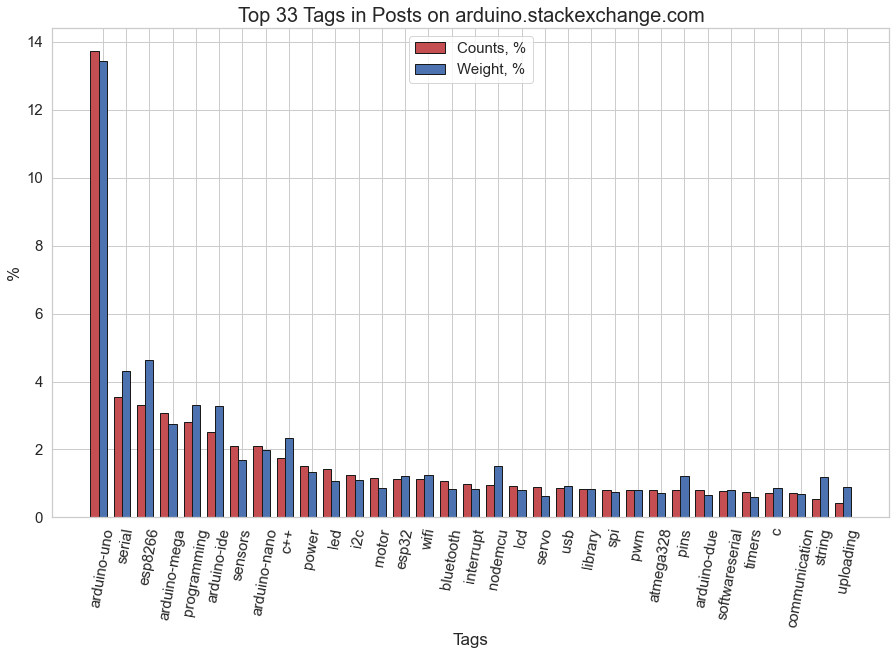

In [69]:
# сравнение популярности топ50+топ 50 тегов по весу и числу

project_id = 3
top = 30

data = data_request(f'SELECT "Tags" FROM public.posts WHERE "ProjectId" = {project_id} AND "Tags" IS NOT NULL;')
dict_counts = dict_to_percents(dict_of_tags(data))
top_50_counts = list_of_popular_tags(dict_counts,top)
tags_count,_ = zip(*top_50_counts)

data = data_request(f'SELECT "Tags","ViewCount","CreationDate" FROM public.posts WHERE "ProjectId" = {project_id} ;')
pub_date = data_request(f'SELECT "publication_date" FROM projects WHERE "id" = {project_id} ;')[0][0]
dict_weights = dict_to_percents(weight_dict_of_tags(data,pub_date))
top_50_weight = list_of_popular_tags(dict_weights,top)
tags_weight,_ = zip(*top_50_weight)

top_100 = set.union(set(tags_count),set(tags_weight))

tags = sorted(list(top_100),key = lambda x: -dict_counts[x])
counts = [dict_counts[tag] for tag in tags]
weights = [dict_weights[tag] for tag in tags]

plot_2_hist(project_id,tags,counts,weights,'Counts, %','Weight, %')

In [27]:
# топ взвешенных тегов по годам 

def top_w_tags_per_years(project_id,start_year,final_year,top, tags, show = True, in_percents = True):
    years = []
    counts = defaultdict(list)
    pub_date = data_request(f'SELECT "publication_date" FROM projects WHERE "id" = {project_id} ;')[0][0]
    for year in range(start_year,final_year + 1):
        data = data_request(f'SELECT "Tags","ViewCount","CreationDate" FROM public.posts WHERE "ProjectId" = {project_id} AND "LastActivityDate" < \'{year}-01-01\' ;')
        if in_percents:
            d = dict_to_percents(weight_dict_of_tags(data,pub_date))
        else:
            d = weight_dict_of_tags(data,pub_date)
        top_n = list_of_popular_tags(d,top)
        years.append(year)
        for tag in tags:
            counts[tag].append(d[tag])
        if show:
            print(year, top_n)
    return (counts,years)
        



2015 []
2016 []
2017 [('neural-networks', 11.332220799904302), ('programming-languages', 8.650277343247438), ('history', 7.441801161576526), ('machine-learning', 6.740911170256891), ('prolog', 6.356608493492201)]
2018 [('neural-networks', 11.46514025831915), ('deep-learning', 8.814622052881077), ('machine-learning', 8.789433942470476), ('convolutional-neural-networks', 5.531009880224348), ('image-recognition', 4.305026617615897)]
2019 [('neural-networks', 13.251275330754627), ('machine-learning', 9.545028682085091), ('deep-learning', 7.7403145397771835), ('reinforcement-learning', 5.510380643130658), ('convolutional-neural-networks', 5.113544793976818)]
2020 [('neural-networks', 8.29686005540531), ('machine-learning', 7.269210698974656), ('reinforcement-learning', 6.099121941629998), ('deep-learning', 5.586093862313271), ('convolutional-neural-networks', 3.993085104371445)]
2021 [('neural-networks', 6.6292625047416225), ('machine-learning', 6.554252933145236), ('reinforcement-learning'

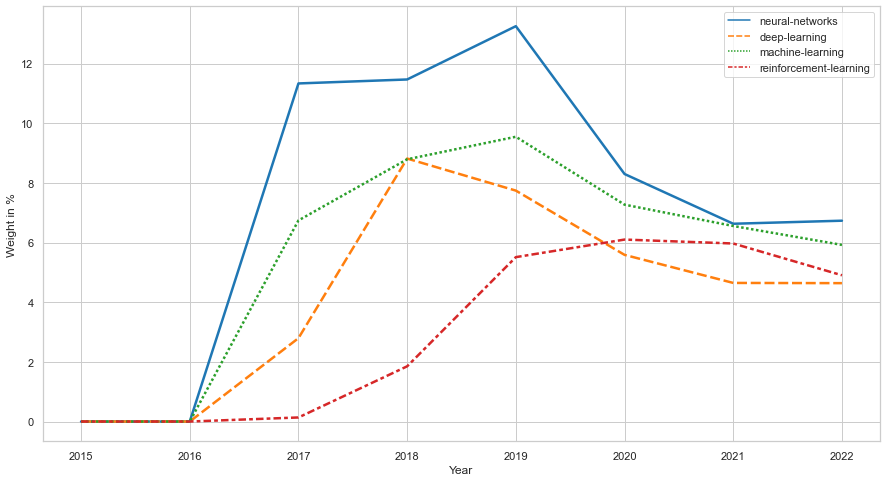

In [30]:
# вес тега по годам в процентах
tags = ['neural-networks','deep-learning','machine-learning','reinforcement-learning']
counts, years = top_w_tags_per_years(8,2015,2022,5, tags, show = 1, in_percents = True)
plot_lineplot(counts,years,ylabel = 'Weight in %')

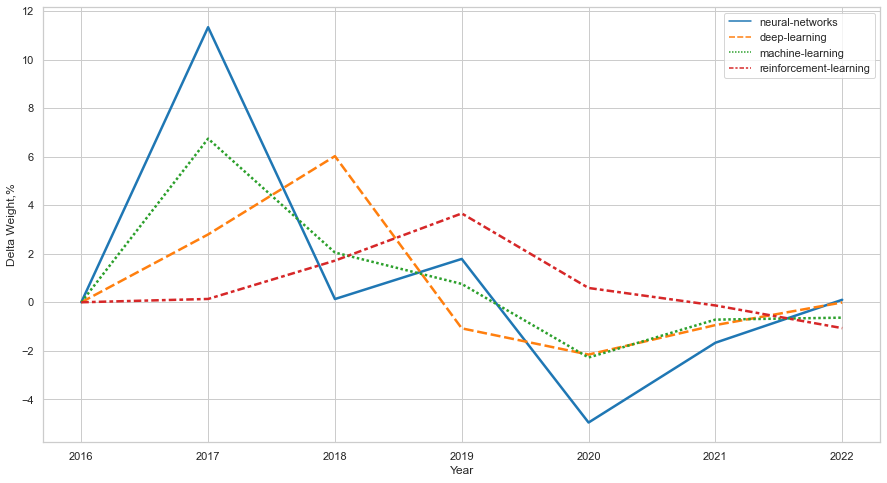

In [31]:
# годовой прирост веса тегов по годам 
deltas = count_deltas(counts)
plot_lineplot(deltas,years[1:],ylabel = 'Delta Weight,%')


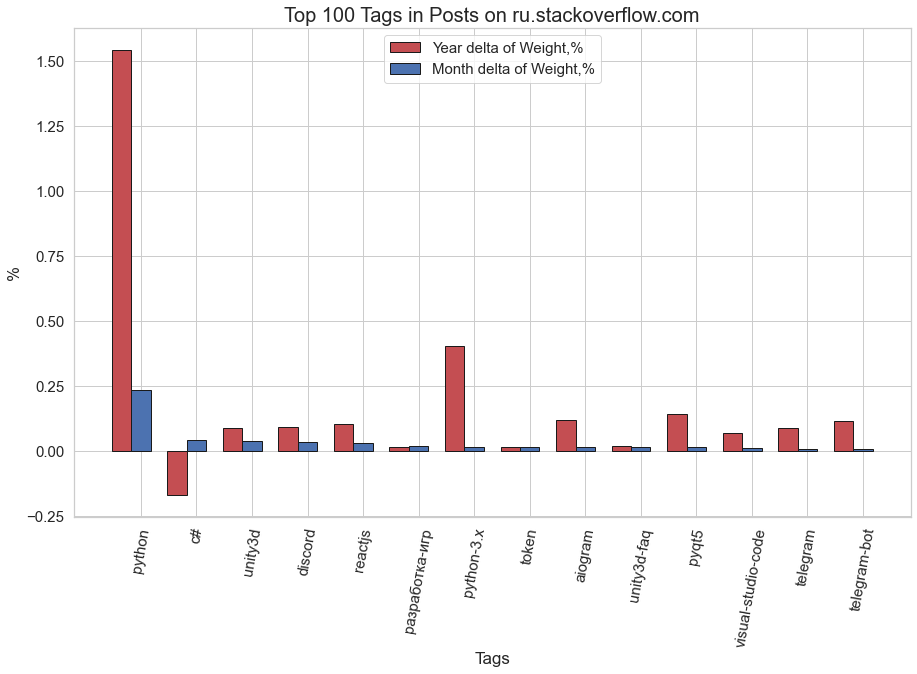

In [136]:
# посмотрим приросты нашего веса за год и за месяц
# TO DO прирост веса в процентах к весу самого тега!!
project_id = 1
top = 10

def delta_in_time(project_id,start_date,final_date):
    d1 = {}
    d2 = {}
    pub_date = data_request(f'SELECT "publication_date" FROM projects WHERE "id" = {project_id} ;')[0][0]
    data = data_request(f'SELECT "Tags","ViewCount","CreationDate" FROM posts WHERE "ProjectId" = {project_id} AND "LastActivityDate" < \'{start_date}\' ;')
    d1 = dict_to_percents(weight_dict_of_tags(data,pub_date))
    data = data_request(f'SELECT "Tags","ViewCount","CreationDate" FROM posts WHERE "ProjectId" = {project_id} AND "LastActivityDate" < \'{final_date}\' ;')
    d2 = dict_to_percents(weight_dict_of_tags(data,pub_date))
    period_delta = {}
    for tag in d2.keys():
        period_delta[tag] = d2[tag] - d1[tag]
    return period_delta



year_delta = delta_in_time(project_id, start_date = '2021-03-01',final_date = '2022-03-01')
month_delta = delta_in_time(project_id,start_date = '2022-02-01',final_date = '2022-03-01')


year_popular = list_of_popular_tags(year_delta,top)
#print('Наибольший прирост веса за год', year_popular)
#plot_hist_top_n(year_popular, project_id, ylabel = 'Delta Weight,%', period = 'per year')
month_popular = list_of_popular_tags(month_delta,top)
#print('Наибольший прирост веса за месяц',month_popular)
#plot_hist_top_n(month_popular, project_id, ylabel = 'Delta Weight,%', period = 'per month')


tags_year,_ = zip(*year_popular)
tags_month,_ = zip(*month_popular)

top_union = set.union(set(tags_year),set(tags_month))

tags = sorted(list(top_union),key = lambda x: -month_delta[x])
year = [year_delta[tag] for tag in tags]
month = [month_delta[tag] for tag in tags]


plot_2_hist(project_id,tags,year,month,'Year delta of Weight,%','Month delta of Weight,%')

Наибольшая метрика [('visual-prolog', 198.9898036131855), ('android-testing', 166.5836974550983), ('bytearray', 104.13345817721738), ('version', 100.20990745773946), ('динамические-массивы', 73.09109033394208), ('phpmailer', 67.04080692403235), ('center', 62.379275979860644), ('preview', 48.77462136990231), ('percona', 43.15014763912103), ('обработка-изображений', 42.59537426619424)]


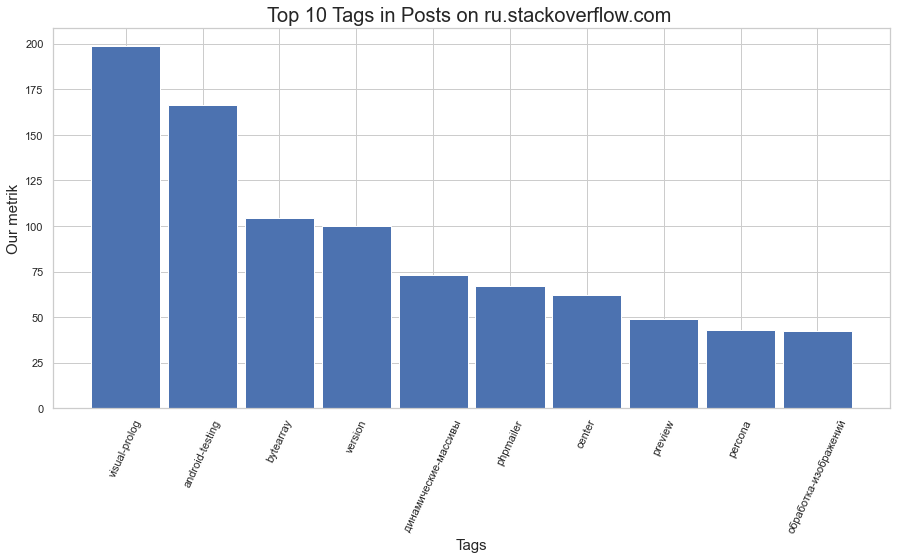

In [137]:
# Наша метрика - прирост веса за месяц/прирост веса за год
metrik ={}
for tag in year_delta.keys():
    if year_delta[tag] != 0:   # надо обсудить!!!!!
        metrik[tag] = month_delta[tag]/year_delta[tag]

metrik_popular = list_of_popular_tags(metrik,top)
print('Наибольшая метрика',metrik_popular)
plot_hist_top_n(metrik_popular, project_id, ylabel = 'Our metrik')



In [138]:
# а сколько всего раз их упоминали?
data = data_request(f'SELECT "Tags","ViewCount","CreationDate" FROM public.posts WHERE "ProjectId" = {project_id} ;')
d = dict_of_tags(data)

tags,_ = zip(*metrik_popular)
for tag in tags:
    print(tag,d[tag])
    
# оказывается страшно мало, для каких-то выводов

visual-prolog 4
android-testing 21
bytearray 26
version 9
динамические-массивы 470
phpmailer 119
center 10
preview 16
percona 8
обработка-изображений 94


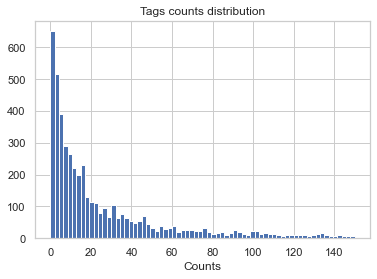

2524.9000000000196


In [139]:
# интересно посмотреть распределение числа упоминаний и наших весов для тегов
project_id = 1

data = data_request(f'SELECT "Tags" FROM public.posts WHERE "ProjectId" = {project_id} AND "Title" IS NOT NULL;')
distr = dict_of_tags(data).values()
plt.hist(distr, bins = 70, range = (0,150))
plt.xlabel('Counts')
plt.title('Tags counts distribution')
plt.show()
cut_from = np.quantile(list(distr),0.99)
print(np.quantile(list(distr),0.99)) #как решить какой квантиль брать?

In [140]:
# решили резать не по квантилю, а по топ 100 по весу

project_id = 1
top = 100

data = data_request(f'SELECT "Tags","ViewCount","CreationDate" FROM public.posts WHERE "ProjectId" = {project_id} ;')
pub_date = data_request(f'SELECT "publication_date" FROM projects WHERE "id" = {project_id} ;')[0][0]
top_100 = list_of_popular_tags(dict_to_percents(weight_dict_of_tags(data,pub_date)),top)
tags_100,_ = zip(*top_100)

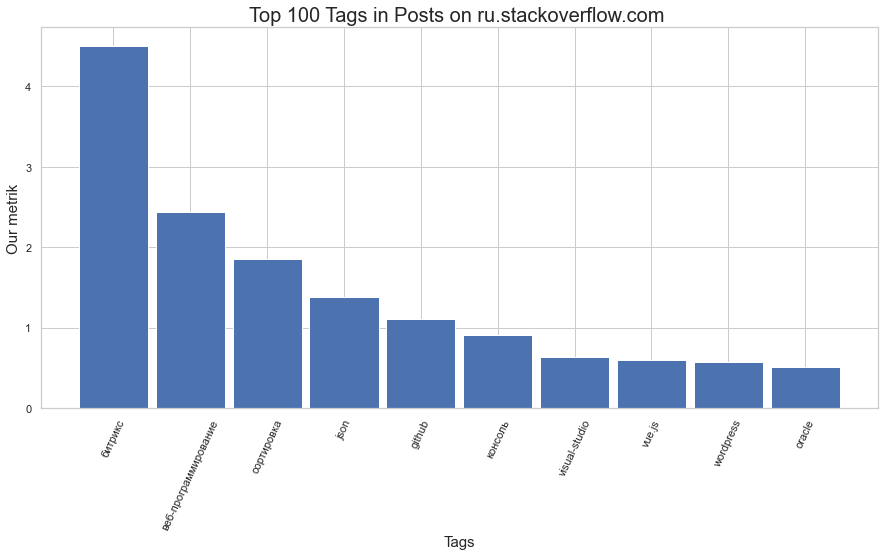

In [141]:
metrik_sufficient = {}

for tag in tags_100:
    metrik_sufficient[tag] = metrik[tag]
    
    
metrik_popular = list_of_popular_tags(metrik_sufficient,10)
#print('Наибольшая метрика у тегов из топ 100 по количеству',metrik_popular)
plot_hist_top_n(metrik_popular, project_id, ylabel = 'Our metrik')

In [142]:
# а сколько всего раз их упоминали? проверим себя
data = data_request(f'SELECT "Tags","ViewCount","CreationDate" FROM public.posts WHERE "ProjectId" = {project_id} ;')
d = dict_of_tags(data)

tags,_ = zip(*metrik_popular)
for tag in tags:
    print(tag,d[tag])
    

битрикс 1441
веб-программирование 3743
сортировка 1515
json 5430
github 1027
консоль 913
visual-studio 2905
vue.js 3179
wordpress 6374
oracle 2033


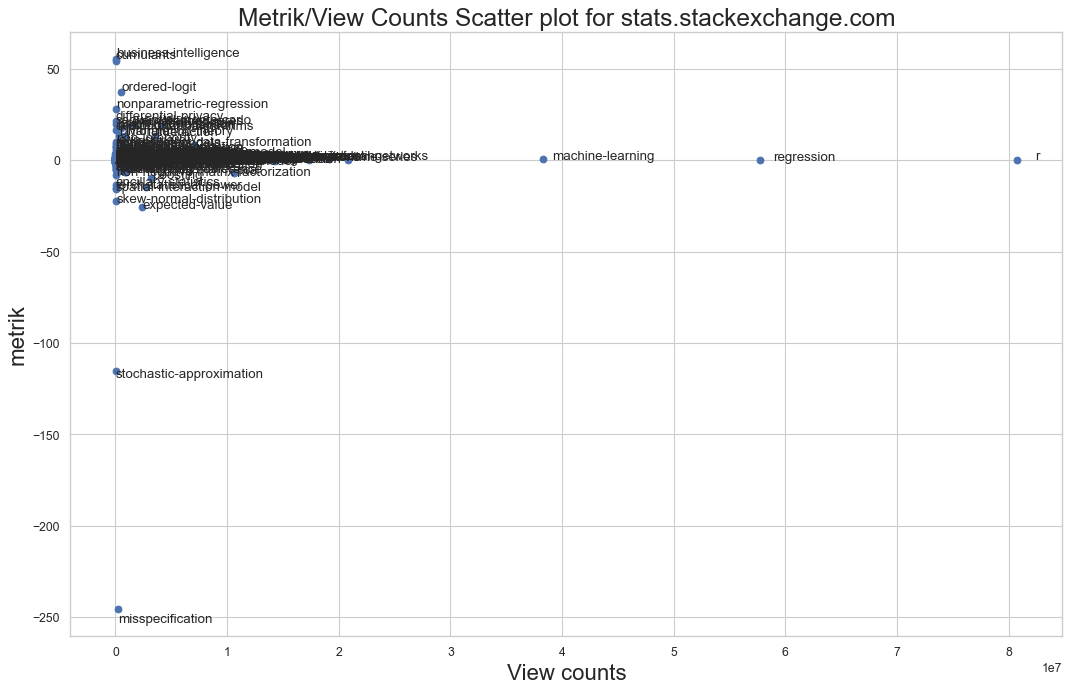

In [250]:
# построим диаграмму рассеивания нашей метрики от ViewCount  тега

project_id = 7

year_delta = delta_in_time(project_id,start_date = '2021-03-01',final_date = '2022-03-01')
month_delta = delta_in_time(project_id,start_date = '2022-02-01',final_date = '2022-03-01')

metrik ={}
for tag in year_delta.keys():
    if year_delta[tag] != 0:   
        metrik[tag] = month_delta[tag]/year_delta[tag]

data = data_request(f'SELECT "Tags","ViewCount" FROM public.posts WHERE "ProjectId" = {project_id} ;')

view_counts = defaultdict(float)
for unit in data:
    if unit[0] is not None:
        for tag in split_tags(unit[0]):
            view_counts[tag] += unit[1]
            
tags = list(metrik.keys())
points = [[view_counts[tag],metrik[tag]] for tag in tags]

plt.subplots(figsize=(16,10), dpi= 80)  
for i in range(len(tags)):
    x = points[i][0]
    y = points[i][1]
    name = tags[i]
    plt.plot(x, y, 'bo')
    # можно включить подписи, в середине будет грязь, зато по краям понятно кто
    plt.text(x * (1 + 0.02), y * (1 + 0.03) , name, fontsize=12)

plt.ylabel('metrik',fontsize=20)
plt.xlabel('View counts',fontsize=20)
plt.title(f'Metrik/View Counts Scatter plot for {projects[project_id-1]}', fontsize=22)
plt.show()

In [341]:
# чистим слова от слишком популярных и стоп слов
def purify(dictionary):
    trash = trash_set()
    for word in copy.deepcopy(dictionary).keys():
        if word.lower() in trash:
            del dictionary[word]
        else:
            dictionary[word.lower()] = dictionary.pop(word)
        
    return dictionary

def trash_set():
    common = []
    with open('/Users/sinya/JB_practice/vocabular.txt', 'r', encoding='utf8') as f: 
        soup = BeautifulSoup(f)
        text = soup.get_text()
        # break into lines and remove leading and trailing space on each
        for line in text.splitlines():
             common += line.strip().split()
            
                
                    
    # build collections of words we need to delete
    english_stopwords = set(stopwords.words("english"))
    russian_stopwords = set(stopwords.words("russian"))
    common_words = set(common)
    specials = set(list(',./?":*(){}[]$``\'<>'))
    
    return english_stopwords | common_words | russian_stopwords | specials


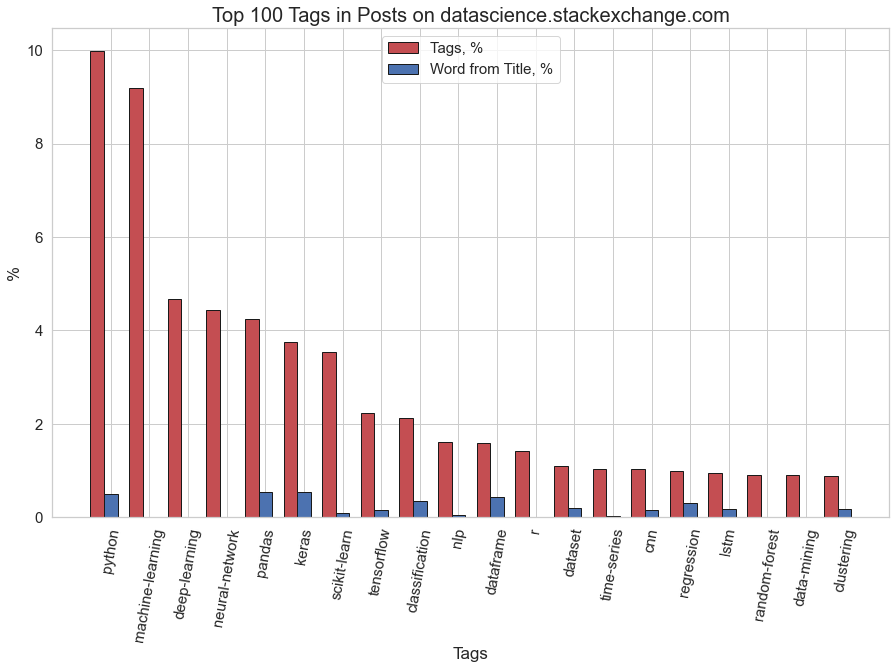

In [342]:
# сравнение веса по тегу и по такому же слову в заголовке среди топ по тегу
project_id = 2
top = 20

data = data_request(f'SELECT "Title","ViewCount","CreationDate" FROM public.posts WHERE "ProjectId" = {project_id} AND "Title" IS NOT NULL;')
pub_date = data_request(f'SELECT "publication_date" FROM projects WHERE "id" = {project_id} ;')[0][0]
dict_title = dict_to_percents(weight_dict_of_tags(data,pub_date,split_fun = lambda x: [el.lower() for el in x.split()]))
# можно использовать nltk.word_tokenize(x), тогда вместе считаются python и python?, но и C и С#
top_title = list_of_popular_tags(purify(dict_title),top)

data = data_request(f'SELECT "Tags","ViewCount","CreationDate" FROM public.posts WHERE "ProjectId" = {project_id} ;')
dict_tags = dict_to_percents(weight_dict_of_tags(data,pub_date))
top_tags = list_of_popular_tags(dict_tags,top)

tags, _ = zip(*top_tags)

tag_arr = [dict_tags[tag] for tag in tags]
title_arr = [dict_title[tag] for tag in tags]

plot_2_hist(project_id,tags,tag_arr,title_arr,'Tags, %','Word from Title, %')

In [343]:
# заготовка для мысли как-то убирать еще и похожие друг на друга слова, но может и не надо..

ps = PorterStemmer()    
example_words = ['earn',"earning","earned","earns"]  
for w in example_words:
    print(ps.stem(w)) 

earn
earn
earn
earn


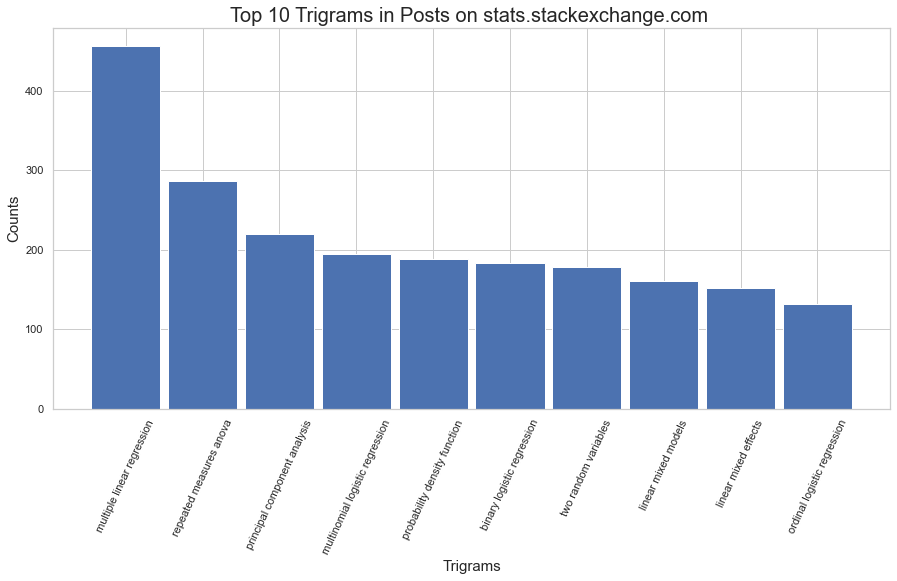

In [357]:
# поищем самые популярные биграммы и триграммы по counts

def split_to_ngrams(title, n, trash):
    # тут уже точно нормально tokenize, просто с# станет биграммой и ладно
    words = [w.lower() for w in nltk.word_tokenize(title) if w not in trash] 
    ngrams = list(nltk.ngrams(words, n))
    return ngrams


project_id = 7
top = 10

data = data_request(f'SELECT "Title" FROM public.posts WHERE "ProjectId" = {project_id} AND "Title" IS NOT NULL;')
trash = trash_set()
d = dict_of_tags(data, split_fun = lambda x: split_to_ngrams(x, 3, trash))
top_10 = list_of_popular_tags(d,top)

# танцы с бубном чтобы избавиться от всевозможных tuple 
def reform(top_n):
    top = top = [list(el) for el in top_n]
    for i,pair in enumerate(top):
        top[i][0] = " ".join(pair[0])
    return top

plot_hist_top_n(reform(top_10), project_id, ylabel = "Counts", xlabel = 'Trigrams')

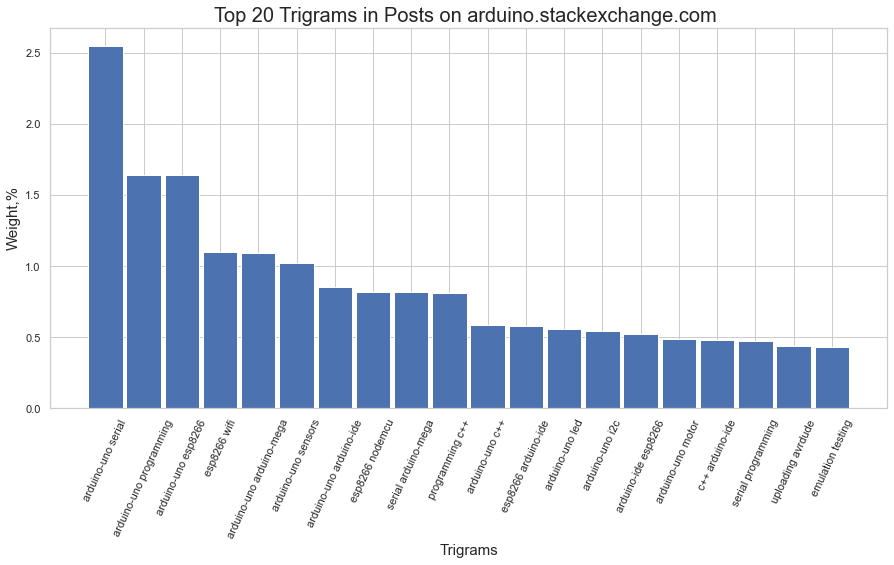

In [360]:
# поищем самые популярные биграммы и триграммы по весу в процентах

project_id = 3
top = 20

data = data_request(f'SELECT "Tags","ViewCount","CreationDate" FROM public.posts WHERE "ProjectId" = {project_id} ;')
pub_date = data_request(f'SELECT "publication_date" FROM projects WHERE "id" = {project_id} ;')[0][0]
d_title = weight_dict_of_tags(data,pub_date,split_fun = lambda x: split_to_ngrams(x, 2, trash))
top_10 = list_of_popular_tags(dict_to_percents(d_title), top)

plot_hist_top_n(reform(top_10), project_id, ylabel = "Weight,%", xlabel = "Trigrams")

In [ ]:
# среди топ 100 найти самые популярные по нашей метрике

In [ ]:
# посчитать TF/IDF?

In [ ]:
# завести в БД записи уже почищенных title

In [ ]:
# научиться считать на стороне БД вес тегов и получать оттуда словарь с каунтами, весами